# Error along the ellipse



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [4]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [5]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.26974167)>
51400.0 pc


In [6]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [7]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 35.08279483 yr>

In [8]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

17.54139741609106 lyr


In [258]:
# should be OK... general ellipse stuff
e = c/a
b = np.sqrt(a**2 - c**2)

# the new angles, defined in the paper

# the angle away from the SNe
Alpha = c1.separation(c0).to('rad')

# oddly, we need to drop the distance to the star, instead use distance to ellipsoid along angle Alpha!
RR = ((b**2) / a) / (1 - (c/a)*np.cos(Alpha))

# the distance from center to the ellipsoid, via law of cosines
# Z = np.sqrt( (c)**2 + d1.to('lyr')**2 - (2 * c * d1.to('lyr') * np.cos(Alpha.to('rad').value)) ) 
Z = np.sqrt( ((c.value)**2 + (RR.to('lyr').value)**2) - (2 * c.value * (RR.to('lyr').value) * 
                                                         np.cos(Alpha.to('rad').value)) ) * u.lyr

# the polar angle (is that the right term?)
# Theta = np.arcsin(np.sin(Alpha.to('rad').value) * d1.to('lyr') / Z) # law of sines
sinTheta = ( np.sin(Alpha.to('rad').value) / Z * RR.to('lyr')) # law of sines
Theta = np.arcsin(sinTheta)

# need to cheeck this math...
# https://math.stackexchange.com/questions/214057/proving-a-property-of-an-ellipse-and-a-tangent-line-of-the-ellipse#comment483262_214088
Phi_not = np.arctan(-b/(a * e * sinTheta)) 

# alternative derviation, gives same answer
# https://math.stackexchange.com/questions/2474291/tangent-angle-to-parametric-ellipse
# Phi_not = np.arctan((b * np.cos(Theta)) / (a * np.sin(Theta)))
Phi_not = np.arctan2(b*np.cos(Theta), a * np.sin(Theta))
# oops, this is the tangent angle of the ellipse relative to Z (which *is* what I asked for...)

# We want to have that angle defined relative to the Earth-Star line (r)
Phi = (Phi_not) - ((np.pi * u.rad) - Alpha - Theta)
Phi

<Angle [-0.49841714, -0.38409008,  1.0526079 , ..., -0.93673637,
         0.91889482, -0.55916603] rad>

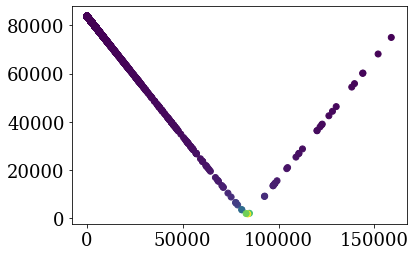

In [250]:
plt.scatter(RR, Z, c = sinTheta)

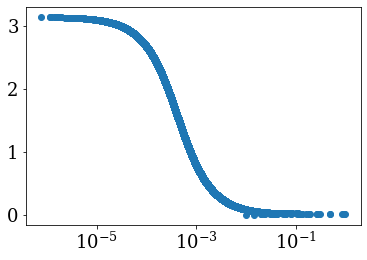

In [255]:
# plt.scatter(sinTheta, Phi_not)
plt.scatter(sinTheta, Alpha)
plt.xscale('log')

In [259]:
Gaia_Err = ((GCNS['DIST_84'] - GCNS['DIST_50']) + (GCNS['DIST_50'] - GCNS['DIST_16']))/2 * u.kpc
PERROR = (Gaia_Err * np.sin(Phi)).to('lyr')
PERROR

<Quantity [-0.27037722, -0.8141044 ,  0.29122525, ..., -0.17090381,
           16.02646783, -4.65834758] lyr>

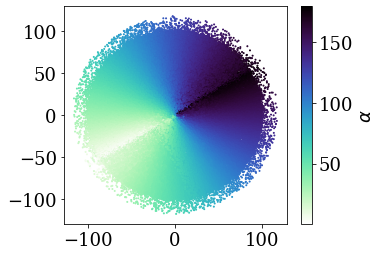

In [241]:
plt.figure(figsize=(5,4))

X1 = np.abs(GCNS['XCOORD_50']) < 15
plt.scatter(GCNS['YCOORD_50'][X1], GCNS['ZCOORD_50'][X1], c=Alpha.to('deg')[X1],s=1, cmap=CMAP1)
cb = plt.colorbar()
cb.set_label(r'$\alpha$')


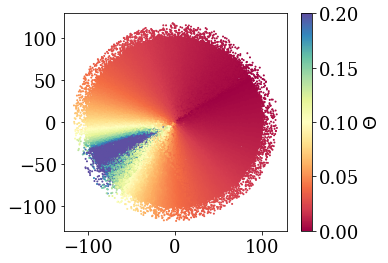

In [260]:
plt.figure(figsize=(5,4))

X1 = np.abs(GCNS['XCOORD_50']) < 15
plt.scatter(GCNS['YCOORD_50'][X1], GCNS['ZCOORD_50'][X1], c=Theta.to('deg')[X1],s=1, cmap=plt.cm.Spectral)#cmap=CMAP1)
cb = plt.colorbar()
cb.set_label('$\Theta$')
plt.clim(0,.2)


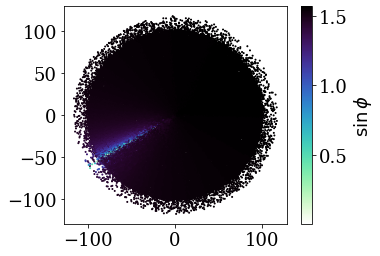

In [264]:
plt.figure(figsize=(5,4))

X1 = np.abs(GCNS['XCOORD_50']) < 15
plt.scatter(GCNS['YCOORD_50'][X1], GCNS['ZCOORD_50'][X1], c=((Phi_not))[X1],s=1, cmap=CMAP1)
cb = plt.colorbar()
cb.set_label(r'$\sin \phi$')


In [244]:
Phi.min()

<Angle -2.83690585 rad>

In [14]:
# A few things to compute for each GCNS object:

# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol


print(len(d1))
print(sum(SNYES), sum(SNNO), sum(EYES), sum(OYES))
print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
192354 138958 25698 141
0.5805826532090598
0.4194173467909403
0.07756435021973246


In [34]:
# functions for drawing ellipses and circles to scale, BUT NOT ROTATED
# b/c I'm lazy...
def echoxy0(t, c, Ntheta=1000, foci=False):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''

    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c**2)))
    
    if foci:
#         foci_length = np.sqrt(np.abs(a**2 - b**2))
        fx = np.array([-c, c]) - c
        fy = np.array([0.,0.])
        return fx* u.lyr, fy* u.lyr

    else:
        theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin

        x = a * np.cos(theta) - c
        y = b * np.sin(theta)
        return x * u.lyr, y * u.lyr
    
    
def circxy0(t, c, x0=None,y0=None, Ntheta=1000):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''
    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    da = np.abs(a - c)
    acirc = a + da + c

    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    
    x = acirc * np.cos(theta) - 2*c 
    y = acirc * np.sin(theta)        

    return x * u.lyr, y * u.lyr

def circxy(t, c, x0, y0, Ntheta=1000):
    r = 2*c + t
    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    x = r * np.cos(theta) + x0
    y = r * np.sin(theta) + y0
    return x * u.lyr, y * u.lyr




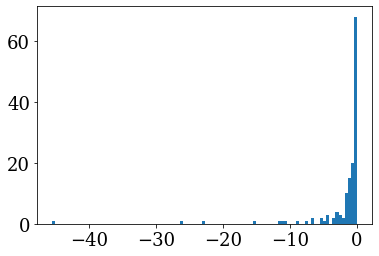

In [35]:
_ = plt.hist(SCATTER.value[OYES],bins=100)

In [36]:
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
c1987_yz = np.sqrt(xyz87.y.to('lyr').value**2 + xyz87.z.to('lyr').value**2)
ang1987_yz = np.arcsin(xyz87.z.to('lyr').value/c1987_yz)
# print(ang1987_yz)

fx0,fy0 = echoxy0(t, c1987_yz/2, foci=True)
fx,fy = echoxy0(t, c1987_yz/2 , Ntheta=10000)

xpos = (fx - fx0[1]).to('pc')
ypos = fy.to('pc')

new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z


xpos0, ypos0 = xpos, ypos
new_xpos0, new_ypos0 = new_xpos, new_ypos

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_7814/3904670271.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('dist_err1_color.pdf', dpi=150, bbox_inches='tight',


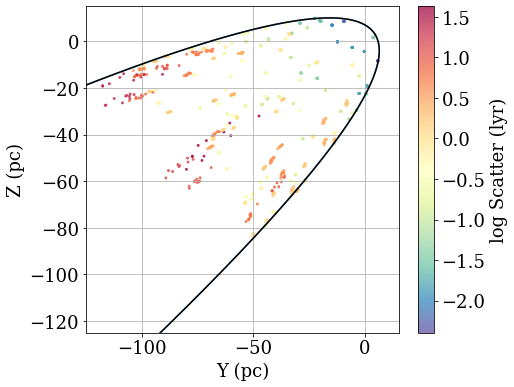

In [214]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(7,6))
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=10
edist_sim = np.zeros((sum(OYES), Nsim))

for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.1, c='C0')

    ddist = np.abs((GCNS['DIST_16'] - GCNS['DIST_84'])/2) * np.random.normal(size=len(GCNS['DIST_50']))
    c1 = SkyCoord(ra = (GCNS['RA']) * u.degree,
              dec = (GCNS['DEC']) * u.degree,
              frame='icrs')
    # directional offset drops distance... so i dont add it until next
    c2 = c1.directional_offset_by(np.random.uniform(high=360,size=len(GCNS['RA']))*u.deg, 
                                  np.sqrt(GCNS['RA_ERROR']**2 + GCNS['DEC_ERROR']**2)*u.deg)
    c3 = SkyCoord(ra=c2.ra, dec=c2.dec,
                  distance= (GCNS['DIST_50'] + ddist) * u.kpc,
                  frame='icrs')
    xyz = c3.transform_to(coord.Galactocentric(z_sun=0, galcen_distance=8*u.kpc))
#     plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
#                 s=20, alpha=0.3, c='r', marker='.')

    d2_k = c3[OYES].separation_3d(c0)

    edist_sim[:,k] = np.abs((c3[OYES].distance.to('lyr').value + d2_k.to('lyr').value) - (2 * a.to('lyr').value))
    
    plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
                s=15, alpha=0.73, c=np.log10(np.abs(PERROR.value[OYES])), marker='.', 
                cmap=plt.cm.Spectral_r,rasterized=True)
cb = plt.colorbar()
cb.set_label('log Scatter (lyr)')

plt.plot(new_xpos0, new_ypos0, c='k')
plt.grid(True)
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-125,15) # center near us
plt.ylim(-125,15)
plt.savefig('dist_err1_color.pdf', dpi=150, bbox_inches='tight', 
            pad_inches=0.25, facecolor='w',rasterized=True)


(-125.0, 15.0)

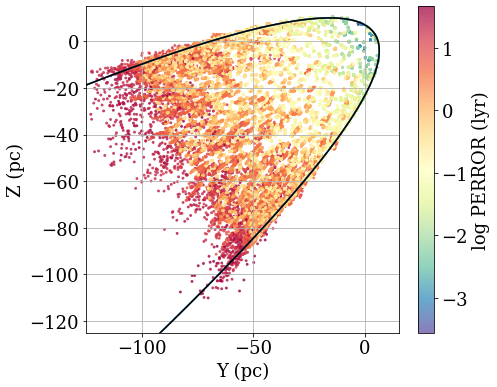

In [215]:
tol = 2 # in lyr
OYES2 = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

# lets inject some errors into the ellipse...
plt.figure(figsize=(7,6))
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=20
edist_sim = np.zeros((sum(OYES2), Nsim))

for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.1, c='C0')

    ddist = np.abs((GCNS['DIST_16'] - GCNS['DIST_84'])/2) * np.random.normal(size=len(GCNS['DIST_50']))
    c1 = SkyCoord(ra = (GCNS['RA']) * u.degree,
              dec = (GCNS['DEC']) * u.degree,
              frame='icrs')
    # directional offset drops distance... so i dont add it until next
    c2 = c1.directional_offset_by(np.random.uniform(high=360,size=len(GCNS['RA']))*u.deg, 
                                  np.sqrt(GCNS['RA_ERROR']**2 + GCNS['DEC_ERROR']**2)*u.deg)
    c3 = SkyCoord(ra=c2.ra, dec=c2.dec,
                  distance= (GCNS['DIST_50'] + ddist) * u.kpc,
                  frame='icrs')
    xyz = c3.transform_to(coord.Galactocentric(z_sun=0, galcen_distance=8*u.kpc))
#     plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
#                 s=20, alpha=0.3, c='r', marker='.')

    d2_k = c3[OYES2].separation_3d(c0)

    edist_sim[:,k] = np.abs((c3[OYES2].distance.to('lyr').value + d2_k.to('lyr').value) - (2 * a.to('lyr').value))
    
    plt.scatter(xyz.y.to('pc').value[OYES2], xyz.z.to('pc').value[OYES2], 
                s=15, alpha=0.73, c=np.log10(np.abs(PERROR.value[OYES2])), marker='.', 
                cmap=plt.cm.Spectral_r,rasterized=True)
cb = plt.colorbar()
cb.set_label('log PERROR (lyr)')

plt.plot(new_xpos0, new_ypos0, c='k')
plt.grid(True)
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-125,15) # center near us
plt.ylim(-125,15)
# plt.savefig('dist_err1_color.pdf', dpi=150, bbox_inches='tight', 
#             pad_inches=0.25, facecolor='w',rasterized=True)



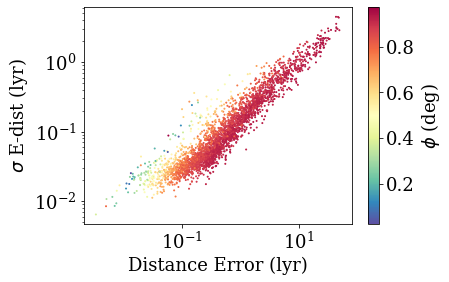

In [218]:
plt.scatter(Gaia_Err.to('lyr')[OYES2], np.std(edist_sim,axis=1), 
            c = (np.abs(np.sin(Phi))[OYES2]), cmap=plt.cm.Spectral_r, s=1)
cb = plt.colorbar()
cb.set_label('$\phi$ (deg)')
plt.xlabel('Distance Error (lyr)')
plt.ylabel('$\sigma$ E-dist (lyr)')
plt.xscale('log')
plt.yscale('log')

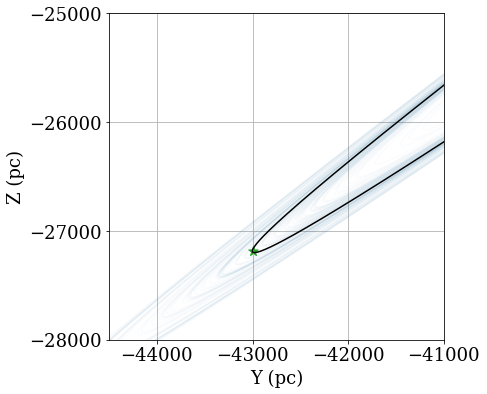

In [38]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=100
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.02, c='C0')
    
plt.plot(new_xpos0, new_ypos0, c='k')
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-44500,-41500) # center near LMC
plt.ylim(-28000,-25000)
plt.xticks([-44000, -43000,-42000, -41000])
plt.yticks([-28000,-27000,-26000,-25000])
plt.grid(True)

# plt.savefig('dist_err2.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


In [46]:
SCATTER

<Quantity [ -0.56184873,  -2.16777352,  -0.33387151, ...,  -0.21166285,
           -20.00141591,  -8.68958002] lyr>